# Analysis of post-workshop survey data which we collect 3-6 months after a workshop

In [403]:
from dataclasses import dataclass

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [404]:
# larger font in seaborn plots
sns.set(font_scale=2)

## Helper functions/ classes

In [405]:
# reduce annoying differences in column titles
def normalize_column_title(s):
    s = s.replace("Post-workshop survey: ", "")
    s = s.replace("Background information: ", "")
    s = s.replace("Impact of the workshop: ", "")
    return s

In [406]:
def extract_typeform_positions(file_name):
    _df = pd.read_csv(file_name)
    # in these datasets the "other" is a separate column
    # in this case fill the "non-other" column with the value from "other"
    _df["What is your current position?"].fillna(_df["Other"], inplace=True)
    return _df["What is your current position?"].to_frame()

In [407]:
def extract_indico_positions(file_name):
    _df = pd.read_csv(file_name)
    _df = _df.rename(normalize_column_title, axis='columns')
    return _df["What is your current position?"].to_frame()

In [408]:
@dataclass
class QualityCount:
    reusable: int = 0
    reproducible: int = 0
    modular: int = 0
    documented: int = 0
    easier_to_collaborate: int = 0
    introduced_colleagues: int = 0
    def add(self, other):
        self.reusable += other.reusable
        self.reproducible += other.reproducible
        self.modular += other.modular
        self.documented += other.documented
        self.easier_to_collaborate += other.easier_to_collaborate
        self.introduced_colleagues += other.introduced_colleagues

In [409]:
def extract_indico_code_quality(file_name):
    _df = pd.read_csv(file_name)
    _df = _df.rename(normalize_column_title, axis='columns')

    count = QualityCount()
    
    for line in _df["Would you judge your code to be better reusable/reproducible/modular/documented as a result of attending the workshop?"]:
        if "More reusable" in line:
            count.reusable += 1
        if "More reproducible" in line:
            count.reproducible += 1
        if "More modular" in line:
            count.modular += 1
        if "Better documented" in line:
            count.documented += 1

    for line in _df["Has it become easier for you to collaborate on software development with your colleagues and collaborators?"]:
        if "Yes" in line:
            count.easier_to_collaborate += 1        

    for line in _df["Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop?"]:
        if "Yes" in line:
            count.introduced_colleagues += 1 
            
    return count

In [410]:
def extract_typeform_code_quality(file_name):
    _df = pd.read_csv(file_name)

    count = QualityCount()
    
    count.reusable += int(_df["Reusable"].sum())
    count.reproducible += int(_df["Reproducible"].sum())
    count.modular += int(_df["Modular"].sum())
    count.documented += int(_df["Documented"].sum())

    c = [col for col in df.columns if 'easier for you to collaborate' in col]
    count.easier_to_collaborate += int(_df[c[0]].sum())
    
    c = [col for col in df.columns if 'introduced one or more' in col]
    count.introduced_colleagues += int(_df[c[0]].sum())

    return count

## Job title/ position/ occupation

In [411]:
positions = pd.concat([
    extract_typeform_positions("data/typeform/2017.csv"),
    extract_typeform_positions("data/typeform/2018.csv"),
    extract_indico_positions("data/indico/2018.csv"),
    extract_indico_positions("data/indico/2019-a.csv"),
    extract_indico_positions("data/indico/2019-b.csv"),
    extract_indico_positions("data/indico/2019-c-2020.csv"),
])["What is your current position?"]

unique_positions = positions.unique()
counts = positions.value_counts()

values summing up to 284


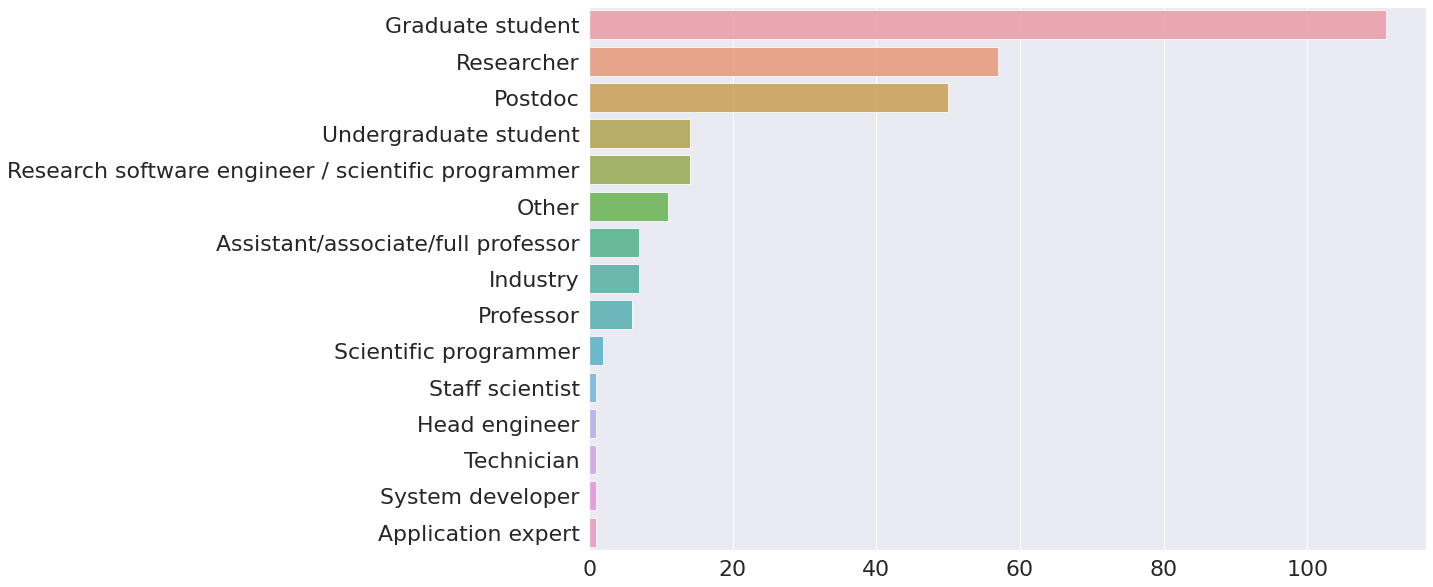

In [412]:
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(y=counts.index.str.capitalize(), x=counts.values, alpha=0.8)

f.savefig("figures/position.png", bbox_inches = 'tight')

print(f"values summing up to {sum(counts.values)}")

## Impact on code quality and collaboration

I didn't use mean() because this gave a different result since it would
ignore those rows where there is no answer and only consider rows with 0 or 1.

In [413]:
num_answers = 0

for file_name in [
    "data/typeform/2017.csv",
    "data/typeform/2018.csv",
    "data/indico/2018.csv",
    "data/indico/2019-a.csv",
    "data/indico/2019-b.csv",
    "data/indico/2019-c-2020.csv",
]:
    _df = pd.read_csv(file_name)
    num_answers += _df.shape[0]

print(f"number of survey respondents: {num_answers}")

number of survey respondents: 285


In [414]:
count = QualityCount()

count.add(extract_typeform_code_quality("data/typeform/2017.csv"))
count.add(extract_typeform_code_quality("data/typeform/2018.csv"))  

count.add(extract_indico_code_quality("data/indico/2018.csv"))
count.add(extract_indico_code_quality("data/indico/2019-a.csv"))
count.add(extract_indico_code_quality("data/indico/2019-b.csv"))
count.add(extract_indico_code_quality("data/indico/2019-c-2020.csv"))

In [415]:
yesno = pd.DataFrame(columns = ['Question', 'Fraction'])

yesno = yesno.append({'Question': 'More reusable?',
                      'Fraction': count.reusable/num_answers},
                     ignore_index = True)
yesno = yesno.append({'Question': 'More reproducible?',
                      'Fraction': count.reproducible/num_answers},
                     ignore_index = True)
yesno = yesno.append({'Question': 'More modular?',
                      'Fraction': count.modular/num_answers},
                     ignore_index = True)
yesno = yesno.append({'Question': 'Better documented?',
                      'Fraction': count.documented/num_answers},
                     ignore_index = True)
yesno = yesno.append({'Question': 'Easier to collaborate?',
                      'Fraction': count.easier_to_collaborate/num_answers},
                     ignore_index = True)
yesno = yesno.append({'Question': 'Introduced tools to colleagues?',
                      'Fraction': count.introduced_colleagues/num_answers},
                     ignore_index = True)

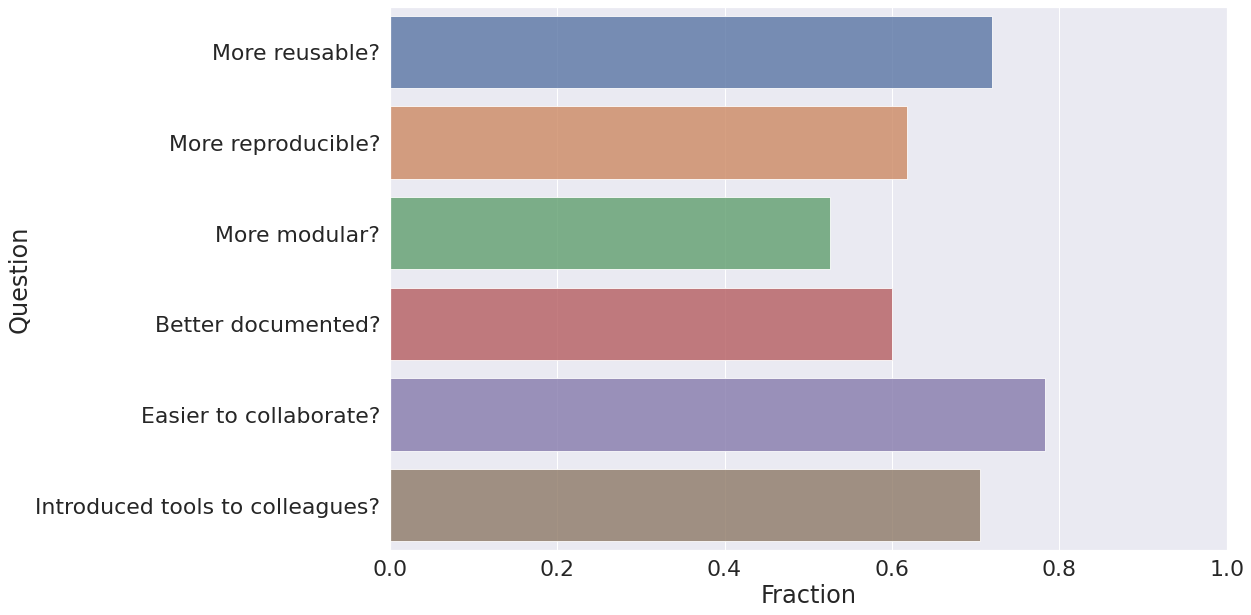

In [416]:
f, ax = plt.subplots(figsize=(15, 10))

g = sns.barplot(y=yesno.Question, x=yesno.Fraction, alpha=0.8)
g.set(xlim=(0.0, 1.0))

f.savefig("figures/yes-no-questions.png", bbox_inches = 'tight')

## Adjusting the dataset

Survey respondents misunderstood the question on "GitHub/GitLab/Bitbucket Pages" in the 2017 survey (RB: can we explain here why we think this question was misunderstood?), and it was therefore merged into the "Read the docs" question in the 2018 survey. We therefore remove the Pages question from 2017 results and rename the Read the docs question.

In [417]:
df_2017 = pd.read_csv("data/typeform/2017.csv")
df_2018 = pd.read_csv("data/typeform/2018.csv")

del df_2017["GitHub/GitLab/BitBucket Pages"]
df_2017.rename(index=str, inplace=True, columns={"Read the docs": "Read the Docs or GitHub/GitLab/BitBucket Pages"})

df = pd.concat([df_2017, df_2018])

In [418]:
num_answers = df.shape[0]
print(f"number of survey respondents: {num_answers}")

number of survey respondents: 92


## Impact on usage of software development tools

In [419]:
table = pd.DataFrame(columns = ['Tool', 'Impact', 'Count'], dtype="float")

d = {}
d["Version control"] = "Version control"
d["Automated testing"] = "Automated testing"
d["Travis CI"] = "Travis CI"
d["Code coverage analysis"] = "Coverage"
d["Jupyter Notebooks"] = "Jupyter"
d["CMake"] = "CMake"
d["Integrated development environments"] = "IDE"
d["Code review"] = "Code review"
d["Read the Docs or GitHub/GitLab/BitBucket Pages"] = "Deploying documentation"

for k, v in d.items():
    table = table.append({'Tool': v,
                          'Impact': 'Not using',
                          'Count': len(df[df[k].str.contains("don't use")])},
                          ignore_index = True)
    table = table.append({'Tool': v,
                          'Impact': 'Started using',
                          'Count': len(df[df[k].str.contains("started using")])},
                          ignore_index = True)
    table = table.append({'Tool': v,
                          'Impact': 'Using better',
                          'Count': len(df[df[k].str.contains("better than before")])},
                          ignore_index = True)
    table = table.append({'Tool': v,
                          'Impact': 'Unchanged',
                          'Count': len(df[df[k].str.contains("same way as before")])},
                          ignore_index = True)
    
result = table.pivot(index='Tool', columns='Impact', values='Count')    

# make sure tools are listed in the same order as added further up
result = result[::-1]

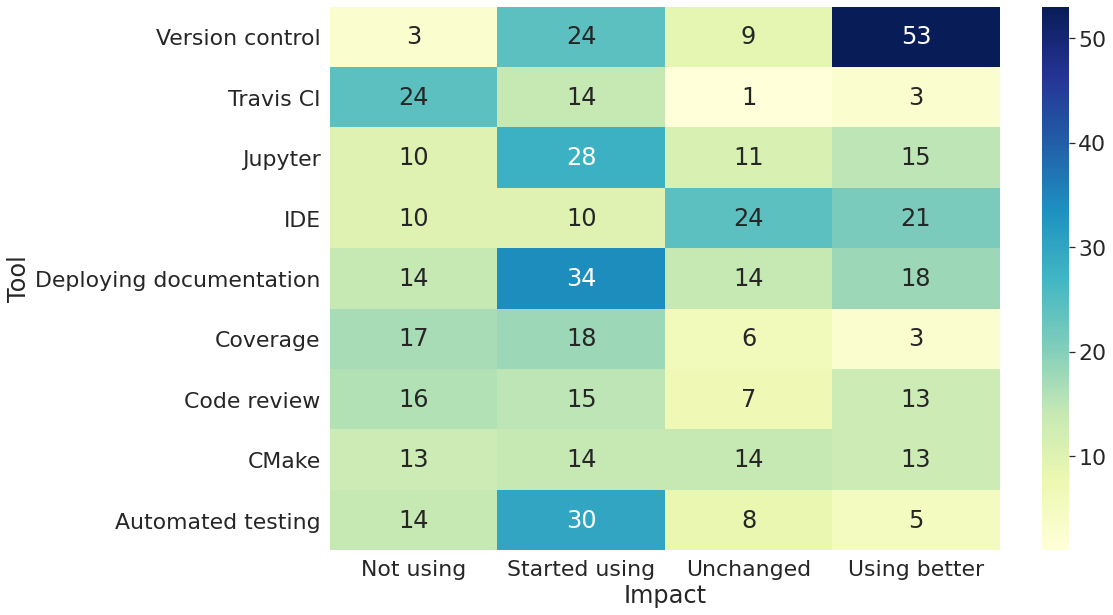

In [420]:
f, ax = plt.subplots(figsize=(15, 10))

g = sns.heatmap(result, fmt="g", cmap="YlGnBu", annot=True)
g.set_yticklabels(g.get_yticklabels(), rotation=0) 

f.savefig("figures/heatmap.png", bbox_inches = 'tight')